In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../kaisr/

/home/remedios/kaisr/kaisr


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np

from pathlib import Path
import nibabel as nib

from utils.plot import *
from utils.train_loader_wavelet_1D import *
from tqdm import tqdm

set_display_mode('dark')
device = device = torch.device(f'cuda:1')

In [4]:
def split_level_idx(coefs, n_levels):
    n = coefs.shape[1]
    
    idxs = [n // 2**i for i in range(1, n_levels+1)]
    idxs.append(idxs[-1])
    idxs.reverse()
    
    sts = [0]
    for i in range(len(idxs)-1):
        sts.append(idxs[i] + sts[i])
    ens = [st + idx for st, idx in zip(sts, idxs)]
    
    return [(slice(None, None), slice(st, en)) for st, en in zip(sts, ens)]

In [5]:
def coefs_to_img_space(coefs, wavelet, n_levels):
    idxs = split_level_idx(coefs, n_levels)
    return pywt.waverec([coefs[idx] for idx in idxs], wavelet=wavelet)

In [6]:
lr_fpath = Path("/home/remedios/data/old/OASIS3/OASIS3_04x_aniso/sub-OAS30003_ses-d0558_run-01_T1w.nii")
lr_vol = nib.load(lr_fpath).get_fdata(dtype=np.float32)

gt_fpath = Path("/home/remedios/data/old/OASIS3/OASIS3_iso/sub-OAS30003_ses-d0558_run-01_T1w.nii.gz")
gt_vol = nib.load(gt_fpath).get_fdata(dtype=np.float32)

lr_vol = np.pad(lr_vol, (((256-176)//2, (256-176)//2), (0, 0), (0, 0)))
gt_vol = np.pad(gt_vol, (((256-176)//2, (256-176)//2), (0, 0), (0, 0)))

In [7]:
slice_profile_fpath = Path("../results/filters/sub-OAS30003_ses-d0558_run-01_T1w/ESPRESO2_output/result.npy")

In [8]:
# TODO: maybe shift around the HR x so we don't learn "zeros at borders"? or do we really have to do patches?

In [9]:
batch_size = 2**8
n_iters = 20000
a = -1
b = 1
scale = 4
lr = 1e-5
use_wavelet = True
discrim_freq = 10

if use_wavelet:
    wavelet = 'haar'
    n_levels = 3
    recon_lambdas = [10**(i) for i in range(n_levels)]
    sparsity_lambdas = [1e-6 for level in range(n_levels)]
    adv_lambdas = [10**(i) for i in range(n_levels)]
    
    recon_lambdas.insert(0, 1) # coarse approximation weighed slightly less
    sparsity_lambdas.insert(0, 0)  # coarse approximation doesn't need to be sparse
    adv_lambdas.insert(0, 1e-1)  # coarse approximation also has adversarial loss
else:
    wavelet = None
    n_levels = None
    recon_lambdas = [1]
    sparsity_lambdas = [1]

In [10]:
class Network(nn.Module):
    def __init__(self, n, features, m):
        super().__init__()
        
        self.body = nn.Sequential(
            nn.Linear(n, features),
            nn.LeakyReLU(),
            nn.Linear(features, features),
            nn.LeakyReLU(),
            nn.Linear(features, m),
        )

    def forward(self, x):
        return self.body(x)
    
class Discriminator(nn.Module):
    def __init__(self, m, features):
        super().__init__()
        
        self.body = nn.Sequential(
            nn.Conv1d(1, features, kernel_size=3, stride=1, padding='same'),
            nn.LeakyReLU(),
            nn.Conv1d(features, features, kernel_size=3, stride=1, padding='same'),
            nn.LeakyReLU(),
            nn.Conv1d(features, 1, kernel_size=3, stride=1, padding='same'),
            nn.AdaptiveAvgPool1d(1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.body(x.unsqueeze(1)).squeeze()

In [11]:
model = Network(
    n=64, 
    features=8192, 
    m=256,
).to(device)

D = Discriminator(
    m=256,
    features=512,
).to(device)

In [12]:
ds = TrainSet(
    vol_fpath=lr_fpath,
    slice_profile_fpath=slice_profile_fpath,
    n_iters=n_iters * batch_size,
    n_levels=n_levels,
    wavelet=wavelet,
    gap=0,
    lr_dim=2,
    a=a,
    b=b,
)

loader = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=8,
)

In [13]:
opt = torch.optim.AdamW(model.parameters(), lr=lr)
opt_D = torch.optim.AdamW(D.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()
adv_loss_fn = torch.nn.BCELoss().to(device)

N_STEPS = n_iters
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=opt,
    max_lr=lr,
    total_steps=N_STEPS+1,
    cycle_momentum=True,
)
opt.step()

scheduler_D = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=opt_D,
    max_lr=lr,
    total_steps=N_STEPS+1,
    cycle_momentum=True,
)
opt_D.step()

In [14]:
real_labels = torch.ones(batch_size, requires_grad=False).to(device)
fake_labels = torch.zeros(batch_size, requires_grad=False).to(device)

with tqdm(total=n_iters) as pbar:
    pbar_dict = {
        'loss': np.finfo(np.float32).max,
        'g_loss': np.finfo(np.float32).max,
        'd_loss': np.finfo(np.float32).max,
    }
    for level in range(n_levels+1):
        pbar_dict[f'r{level}'] = np.finfo(np.float32).max
        pbar_dict[f's{level}'] = np.finfo(np.float32).max

        
    for cur_step, (ys_cpu, xs_cpu) in enumerate(loader):
        N = ys_cpu.shape[0]

        ys = ys_cpu.to(device)
        xs = xs_cpu.to(device)
        
        ########## Train the SR Network ##########
        # freeze the discriminator
        for p in D.parameters():
            p.requires_grad = False
        
        opt.zero_grad()
        
        xs_hat = model(ys)
        
        # recon loss and sparsity loss on non-coarse coefs

        # separate loss by level
        idxs = split_level_idx(xs_hat, n_levels)
        recon_losses = [recon_lambda * loss_fn(xs_hat[idx], xs[idx]) 
                        for recon_lambda, idx in zip(recon_lambdas, idxs)]
        sparsity_losses = [sparsity_lambda * torch.linalg.vector_norm(xs_hat[idx], ord=1)
                            for sparsity_lambda, idx in zip(sparsity_lambdas, idxs)]
        adv_losses = [adv_lambda * adv_loss_fn(D(xs_hat[idx]), real_labels[:N])
                      for adv_lambda, idx in zip(adv_lambdas, idxs)]
        loss = 0
        g_loss = 0
        for level in range(n_levels + 1):
            g_loss += adv_losses[level]
            loss += recon_losses[level] + sparsity_losses[level] + adv_losses[level]
            
            # progress bar
            pbar_dict[f'r{level}'] = recon_losses[level].detach().cpu().numpy().item()
            pbar_dict[f's{level}'] = sparsity_losses[level].detach().cpu().numpy().item()

        loss.backward()
        opt.step()
        scheduler.step()
        
        
        ########## Train the Discriminator ##########
        if cur_step % discrim_freq == 0:
            # unfreeze the discriminator
            for p in D.parameters():
                p.requires_grad = True

            opt_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            if np.random.rand() < 0.5:
                d_losses = [adv_lambda * adv_loss_fn(D(xs[idx]), real_labels[:N])
                            for adv_lambda, idx in zip(adv_lambdas, idxs)]
            else:
                d_losses = [adv_lambda * adv_loss_fn(D(xs_hat[idx].detach()), fake_labels[:N])
                            for adv_lambda, idx in zip(adv_lambdas, idxs)]

            d_loss = 0
            for level in range(n_levels + 1):
                d_loss += d_losses[level]
            d_loss.backward()
            opt_D.step()
            scheduler_D.step()
        

        pbar_dict['loss'] = loss.detach().cpu().numpy().item()
        pbar_dict['g_loss'] = g_loss.detach().cpu().numpy().item()
        pbar_dict['d_loss'] = d_loss.detach().cpu().numpy().item()
        pbar.set_postfix({k: f'{100*v:.2f}' for k, v in pbar_dict.items() if v != 0})
        pbar.update(1)

100%|███| 20000/20000 [19:12<00:00, 17.36it/s, loss=7441.35, g_loss=7425.08, d_loss=7971.91, r0=0.05, r1=0.19, s1=0.03, r2=2.06, s2=0.03, r3=12.81, s3=1.10]


# Evaluation on self

In [15]:
# normalize entire volume's intensity
lr_vol_norm, orig_min, orig_max = normalize(lr_vol, a=a, b=b)
lr_vol_norm = torch.from_numpy(lr_vol_norm)

In [16]:
# pull a slice
lr_img = lr_vol_norm[128]

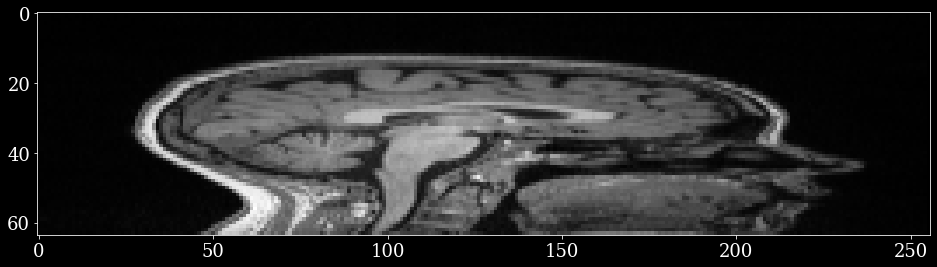

In [17]:
plt.imshow(np.rot90(lr_img))

In [18]:
if use_wavelet:
    # wavelet transform
    lr_coefs = np.concatenate(pywt.wavedec(lr_img, wavelet=wavelet, level=n_levels), axis=1)
    lr_coefs = torch.from_numpy(lr_coefs)
    # run through model
    sr_coefs = model(lr_coefs.to(device)).detach().cpu().numpy()
    # to image
    sr_img = coefs_to_img_space(sr_coefs, wavelet, n_levels)
else:
    sr_img = model(lr_img.to(device)).detach().cpu().numpy()

In [19]:
# crop and compare to gt
gt_img = gt_vol[128]
gt_img, *_ = normalize(gt_img, a=a, b=b)

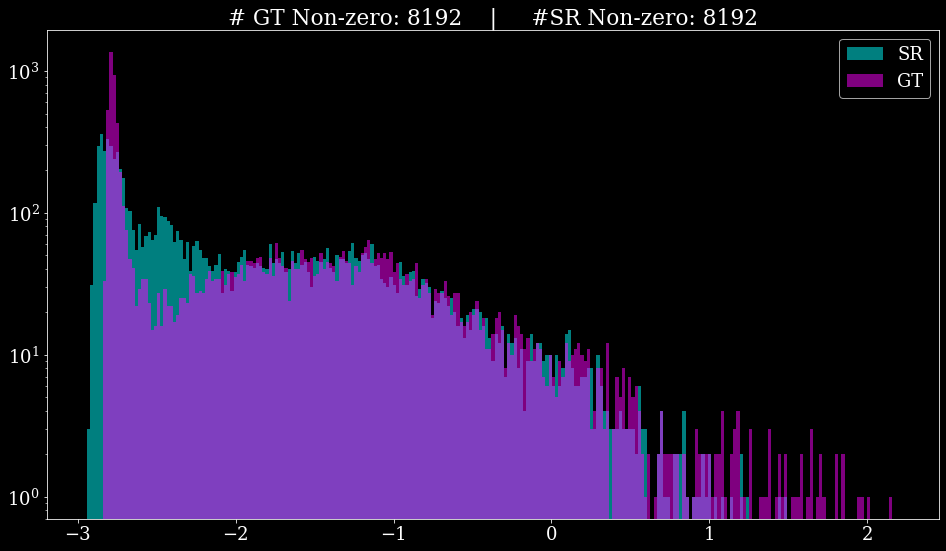

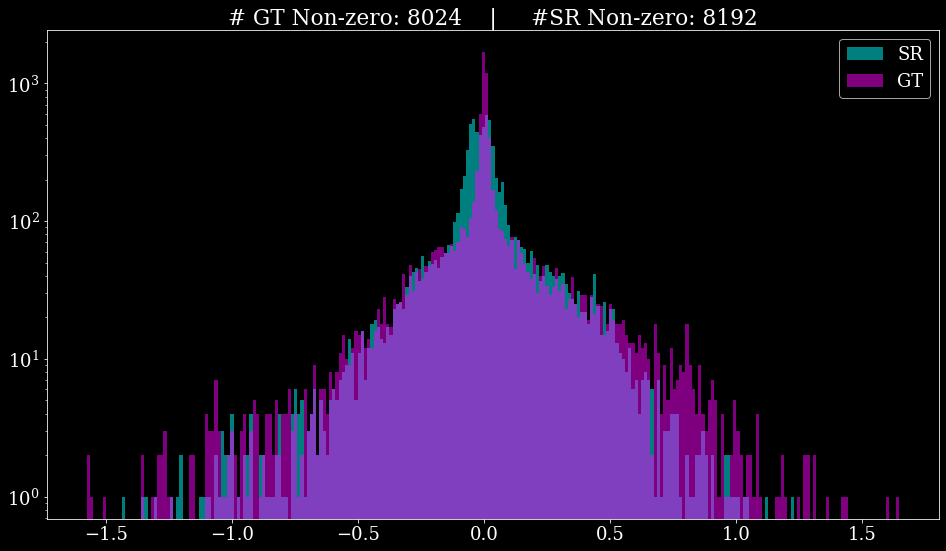

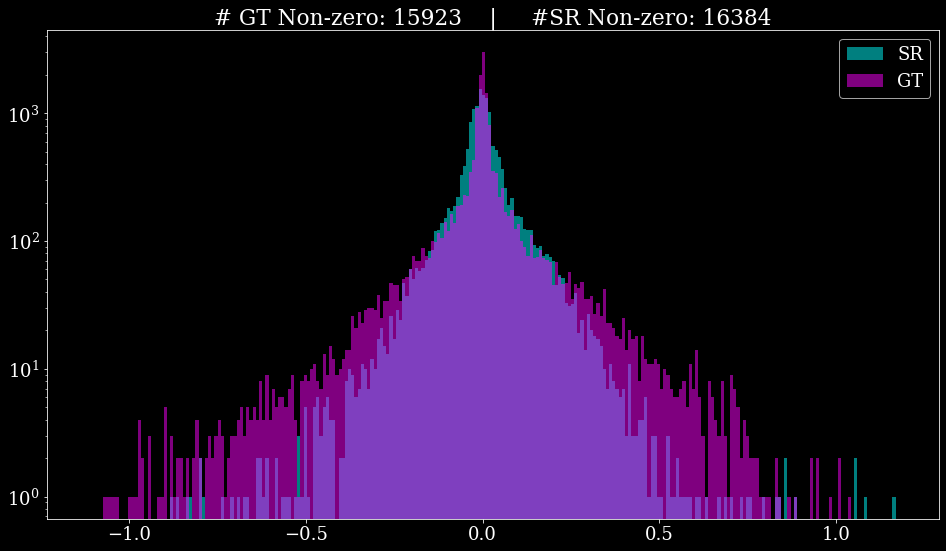

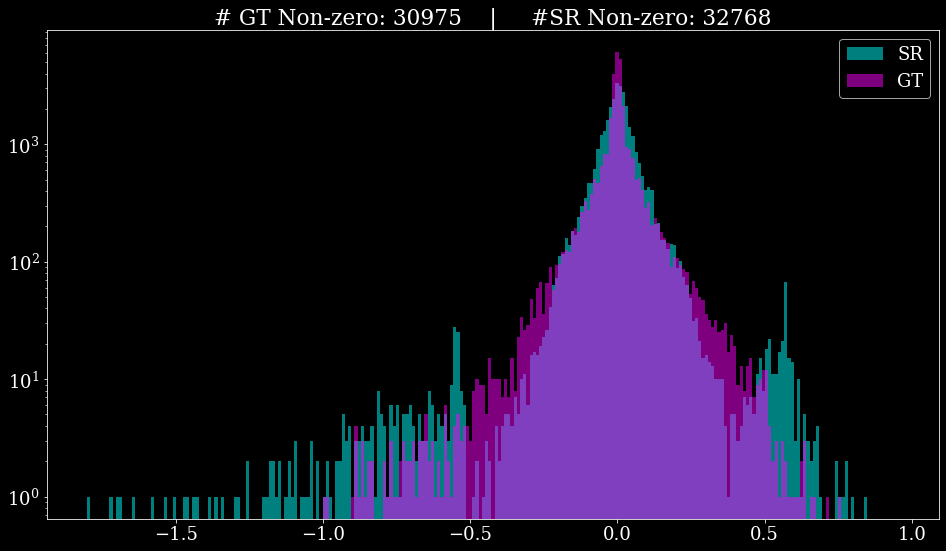

In [20]:
sr_coefs_list = list(pywt.wavedec(sr_img, wavelet=wavelet, level=n_levels))
gt_coefs_list = list(pywt.wavedec(gt_img, wavelet=wavelet, level=n_levels))

n_bins = 256


# Visualize coefficients compared
for sr_coef, gt_coef in zip(sr_coefs_list, gt_coefs_list):
    
    bins = np.round(np.linspace(
        min(sr_coef.min(), gt_coef.min()),
        max(sr_coef.max(), gt_coef.max()), 
        n_bins), 4)
    
    plt.hist(sr_coef.flatten(), bins=bins, color='cyan', alpha=0.5, label='SR')
    plt.hist(gt_coef.flatten(), bins=bins, color='magenta', alpha=0.5, label='GT')
    plt.legend()
    plt.title(f"# GT Non-zero: {np.count_nonzero(gt_coef)}    |     #SR Non-zero: {np.count_nonzero(sr_coef)}")
    plt.yscale('log')
    plt.show()

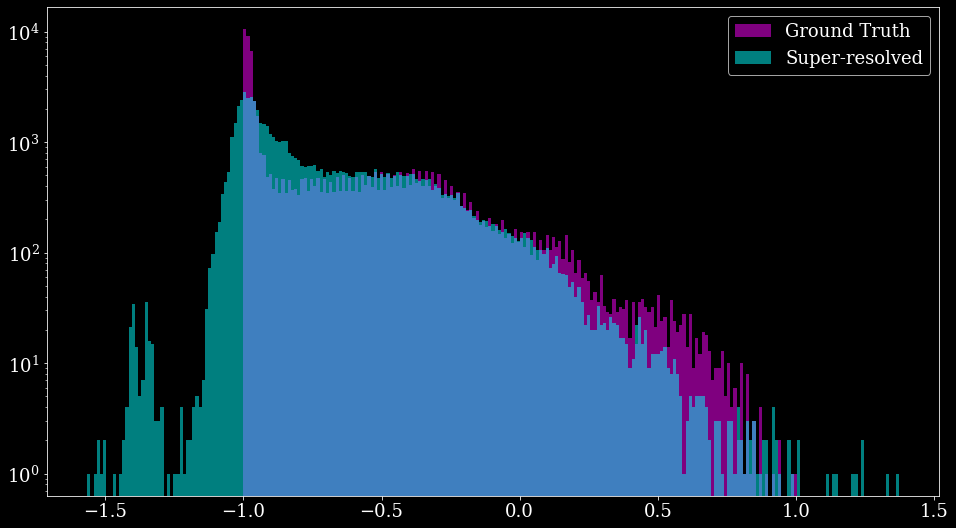

In [21]:
bins = np.round(np.linspace(
        min(sr_img.min(), gt_img.min()),
        max(sr_img.max(), gt_img.max()), 
        n_bins), 4)

plt.hist(gt_img.flatten(), bins=bins, label='Ground Truth', color='magenta', alpha=0.5)
plt.hist(sr_img.flatten(), bins=bins, label='Super-resolved', color='cyan', alpha=0.5)
plt.legend()
plt.yscale('log')
plt.show()

In [22]:
# degrade GT, interpolate
from resize.scipy import resize

In [23]:
gt_deg = (ds.A @ gt_img.T).T
gt_deg_interp = resize(gt_deg, (1, 0.25), order=3)

In [24]:
lr_img_interp = resize(lr_img, (1, 0.25), order=0)

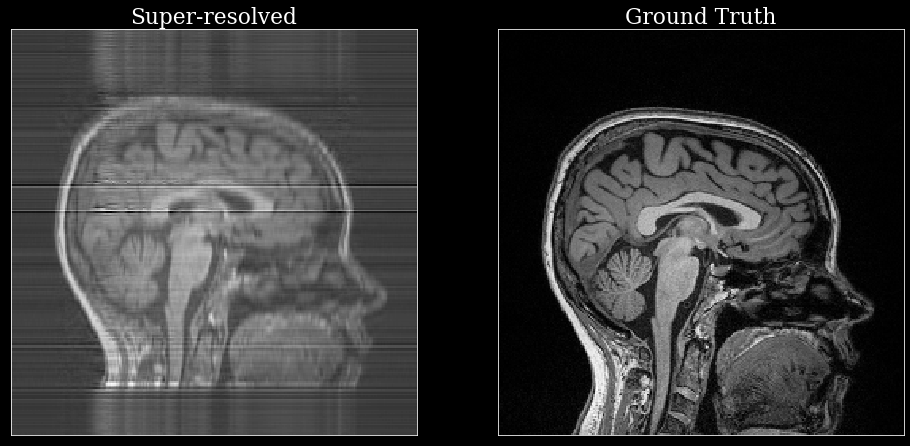

In [25]:
multiplot(
    [#lr_img_interp, 
     sr_img, gt_img], 
    titles=[#'LR Input', 
            'Super-resolved', 'Ground Truth'],
)

# Debugging $A$ construction...

In [26]:
lr_img_interp = resize(lr_img, (1, 0.25), order=0)[:, 5:]
gt_deg_interp = resize(gt_deg, (1, 0.25), order=0)[:, :-5]

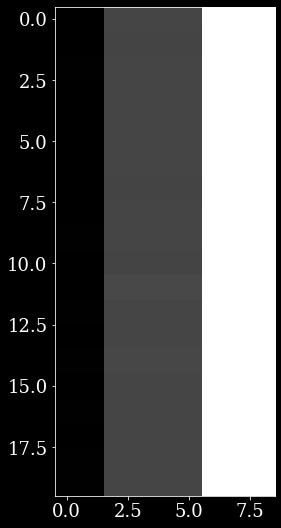

In [27]:
plt.imshow(gt_deg_interp[:20, -9:])

In [28]:
diff = np.abs(lr_img_interp - gt_deg_interp)

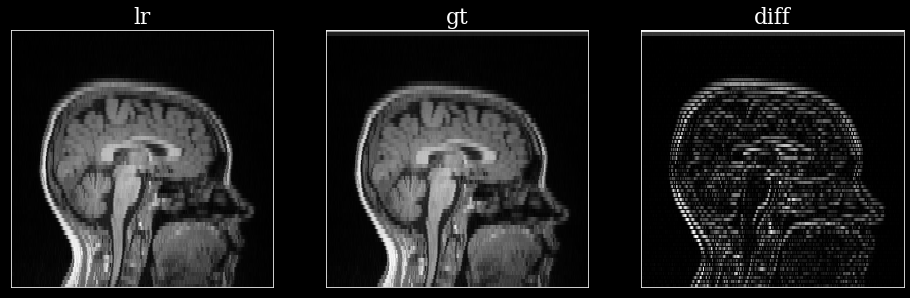

In [29]:
multiplot([lr_img_interp, gt_deg_interp, diff], ['lr', 'gt', 'diff'])

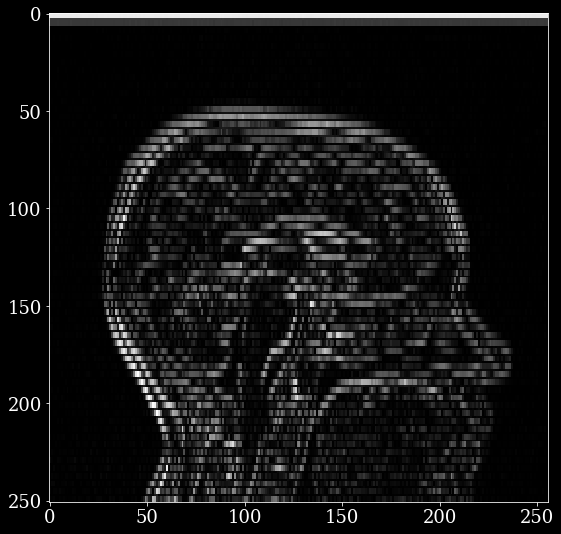

In [30]:
plt.imshow(np.rot90(diff))

# What is the coherence of $A$?

In [31]:
A = ds.A

In [32]:
def coherence(mat):
    vals = []
    for i in range(mat.shape[1]):
        for j in range(mat.shape[1]):
            
            if i == j:
                continue
                
            a = mat[:, i]
            b = mat[:, j]
            
            numer = torch.abs(torch.inner(a, b))
            denom = torch.linalg.vector_norm(a, ord=2) * torch.linalg.vector_norm(b, ord=2)

            vals.append(numer / denom)
    return max(vals).item()

In [33]:
coherence(ds.A)

1.0

In [34]:
# what about a random matrix?
B = torch.randn((64, 256))
coherence(B)

0.45896604657173157

In [35]:
np.sqrt((256 - 64) / (256 * (64-1)))

0.10910894511799618

# Therefore, we can't do CS directly for super-res here, or possibly in general. The matrix $A$ is too coherent, at least in the image basis

# Turning that ESPRESO filter into a HPF

In [142]:
def to_hpf(f):
    '''
    1. FFT
    2. Flip left/right
    3. alternate signs
    4. IFFT
    '''
    
    x = np.fft.fftshift(np.fft.fft(f))
    x = x[::-1]
    alt = np.array([(-1)**i for i in range(len(x))])
    x = x * alt
    
    # renormalize
    x = np.fft.ifftshift(np.fft.ifft(x)).real
    x /= np.sum(np.abs(x))
    
    return x.astype(np.float32)

In [177]:
lpf = np.load(slice_profile_fpath)

In [178]:
lpf_freq = np.fft.fftshift(np.fft.fft(lpf))

In [179]:
hpf = to_hpf(lpf)

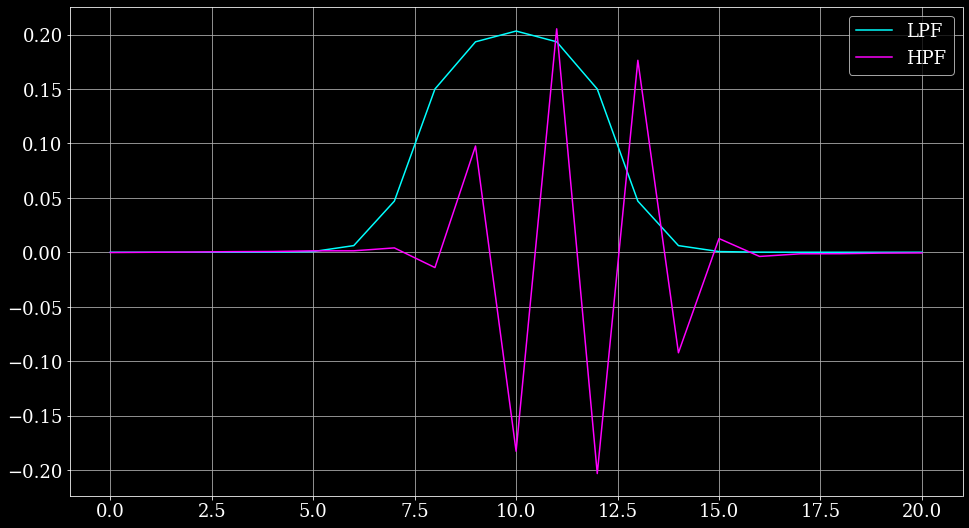

In [195]:
plt.plot(lpf, color='cyan', label='LPF')
plt.plot(hpf, color='magenta', label='HPF')
plt.grid()
plt.legend()
plt.show()

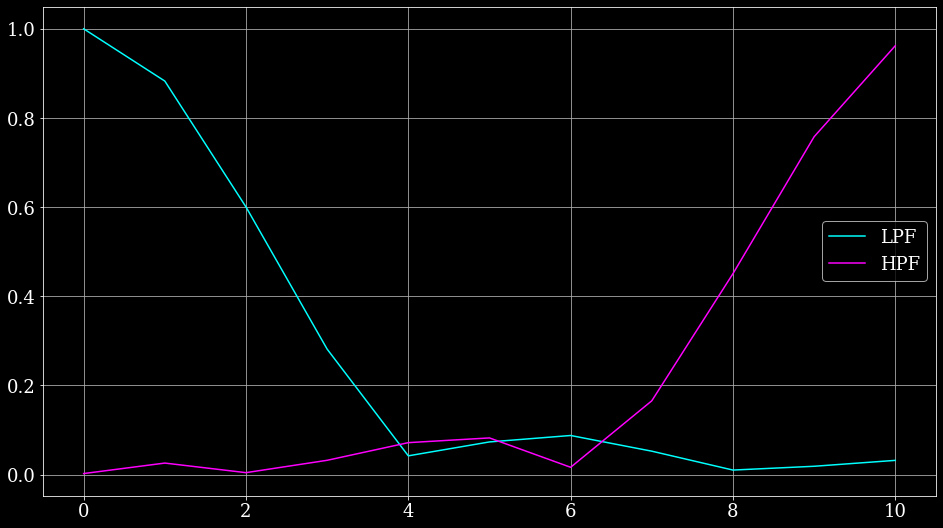

In [204]:
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(lpf)))[L//2:], color='cyan', label='LPF')
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(hpf)))[L//2:], color='magenta', label='HPF')
plt.grid()
plt.legend()
plt.show()

In [189]:
# plot frequency response
L = len(lpf)
lpf_freq_response = np.abs(np.fft.fft(lpf)).squeeze()[0 : L // 2 + 1]
hpf_freq_response = np.abs(np.fft.fft(hpf)).squeeze()[0 : L // 2 + 1]

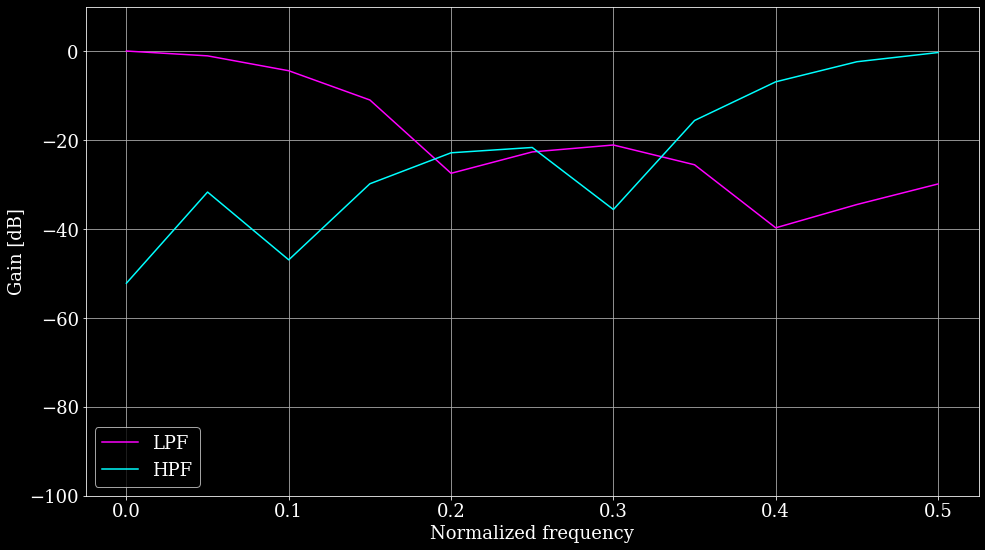

In [193]:
plt.plot(np.linspace(0, 0.5, len(lpf_freq_response)), 20 * np.log10(lpf_freq_response),
         color='magenta', label='LPF')
plt.plot(np.linspace(0, 0.5, len(hpf_freq_response)), 20 * np.log10(hpf_freq_response),
         color='cyan', label='HPF')

plt.xlabel('Normalized frequency')
plt.ylabel('Gain [dB]')
plt.ylim([-100, 10])
plt.grid()
plt.legend()
plt.show()

In [145]:
np.sum(np.abs(lpf))

1.0

In [146]:
np.sum(np.abs(hpf))

1.0

In [147]:
# example signal of random noise
x = np.random.rand(128).astype(np.float32)

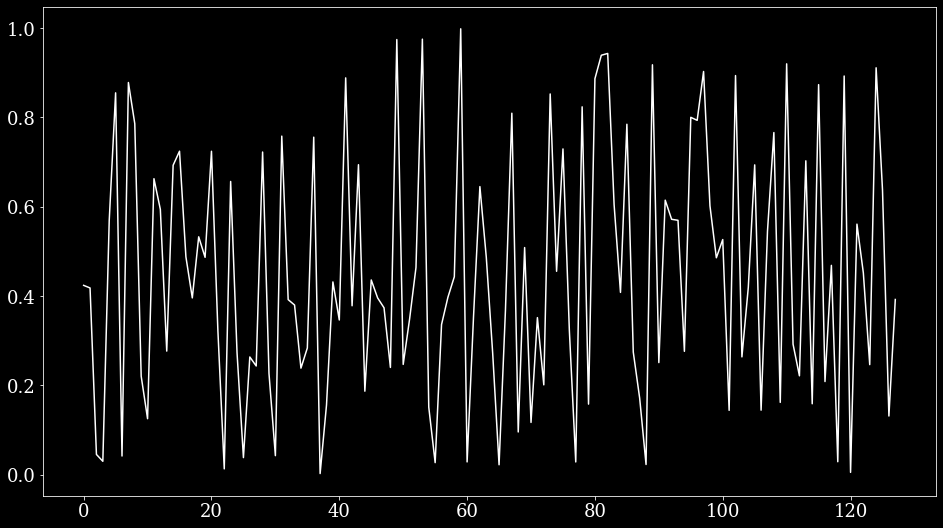

In [148]:
plt.plot(x)

In [149]:
x = torch.from_numpy(x).unsqueeze(0).unsqueeze(1)
lpf = torch.from_numpy(lpf).unsqueeze(0).unsqueeze(1)
hpf = torch.from_numpy(hpf).unsqueeze(0).unsqueeze(1)

In [150]:
c = torch.nn.functional.conv1d(x, lpf, stride=1, padding='same')
d = torch.nn.functional.conv1d(x, hpf, stride=1, padding='same')

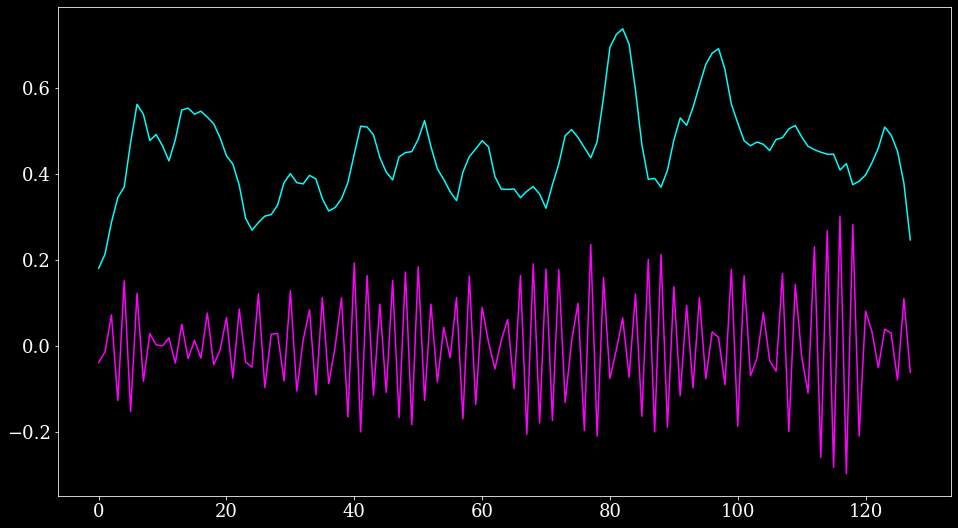

In [154]:
plt.plot(c.squeeze().numpy(), label='LPF signal', color='cyan')
plt.plot(d.squeeze().numpy(), label='HPF signal', color='magenta')

In [156]:
# TODO: construct f_0, f_1, try perfect reconstruction
# TODO: implement downsampling
# TODO: question: does downsampling != 2 mean we need more detail coefficients? check notes